In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import PIL

In [2]:
TYPE_DATA_FOLDER_PATH  = "..\\data\\grouped_images_by_type"
AKIEC_DATA_FOLDER_PATH = "..\\data\\grouped_images_by_type\\akiec\\*"
BCC_DATA_FOLDER_PATH   = "..\\data\\grouped_images_by_type\\bcc\\*"
BKL_DATA_FOLDER_PATH   = "..\\data\\grouped_images_by_type\\bkl\\*"
DF_DATA_FOLDER_PATH    = "..\\data\\grouped_images_by_type\\df\\*"
MEL_DATA_FOLDER_PATH   = "..\\data\\grouped_images_by_type\\mel\\*"
NV_DATA_FOLDER_PATH    = "..\\data\\grouped_images_by_type\\nv\\*"
VASC_DATA_FOLDER_PATH  = "..\\data\\grouped_images_by_type\\vasc\\*"
AKIEC_DATA_FOLDER_PATH_TEST = "..\\data\\secret_test_folder\\akiec\\*"
BCC_DATA_FOLDER_PATH_TEST   = "..\\data\\secret_test_folder\\bcc\\*"
BKL_DATA_FOLDER_PATH_TEST   = "..\\data\\secret_test_folder\\bkl\\*"
DF_DATA_FOLDER_PATH_TEST    = "..\\data\\secret_test_folder\\df\\*"
MEL_DATA_FOLDER_PATH_TEST   = "..\\data\\secret_test_folder\\mel\\*"
NV_DATA_FOLDER_PATH_TEST    = "..\\data\\secret_test_folder\\nv\\*"
VASC_DATA_FOLDER_PATH_TEST  = "..\\data\\secret_test_folder\\vasc\\*"
TARGET_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 20

In [3]:
imgs_BKL    = glob.glob(BKL_DATA_FOLDER_PATH)
imgs_AKIEC    = glob.glob(AKIEC_DATA_FOLDER_PATH)

test_imgs_BKL    = glob.glob(BKL_DATA_FOLDER_PATH_TEST)
test_imgs_AKIEC     = glob.glob(AKIEC_DATA_FOLDER_PATH_TEST)

df_BKL = pd.DataFrame({'filename': imgs_BKL})
df_BKL['class'] = 'BKL'
df_AKIEC = pd.DataFrame({'filename': imgs_AKIEC})
df_AKIEC['class'] = 'AKIEC'

df_test_BKL = pd.DataFrame({'filename': test_imgs_BKL})
df_test_BKL['class'] = 'BKL'
df_test_AKIEC = pd.DataFrame({'filename': test_imgs_AKIEC})
df_test_AKIEC['class'] = 'AKIEC'

BKL = 'BKL'
AKIEC = 'AKIEC'

df_layer1_bkl_akiec = pd.concat([df_BKL, df_AKIEC])
df_layer1_bkl_akiec_test = pd.concat([df_test_BKL, df_test_AKIEC])

df, df_val = train_test_split(df_layer1_bkl_akiec, stratify=df_layer1_bkl_akiec["class"], test_size=.08)

In [4]:
data_generator_vis = ImageDataGenerator()
flow_vis = data_generator_vis.flow_from_directory(
    TYPE_DATA_FOLDER_PATH,
    shuffle=False
)

Found 19329 images belonging to 7 classes.


In [5]:
data_generator_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    shear_range=.1,
    brightness_range=[0.6,1.0]
)

data_generator_val = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

data_generator_test = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [6]:
flow_train = data_generator_train.flow_from_dataframe(
    df,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

flow_val = data_generator_val.flow_from_dataframe(
    df_val,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
    
)

flow_test = data_generator_test.flow_from_dataframe(
    df_layer1_bkl_akiec_test,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2471 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
Found 89 validated image filenames belonging to 2 classes.


In [7]:
EfficientNet = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='max'
)

In [8]:
def get_model(base_model, activation="softmax", optimizer: str="adam", loss_function: str="CategoricalCrossentropy"):
    model = Sequential([
        base_model,
        Dropout(.2),
        Dense(2, activation=activation)
    ])
    
    for layer in model.layers[:-1]:
        layer.trainable=True
        
    model.compile(
        optimizer,
        loss_function,
        metrics=[
            "accuracy"
        ]
    )
    
    return model

In [9]:
model_eff_layer1 = get_model(EfficientNet)

In [67]:
model_eff_layer2 = load_model(r"D:\Projects\thesis\src\model\cascade\layer2\experimental_model_layer2.h5")

In [52]:
history_eff2 = model_eff_layer1.fit(
    flow_train,
    validation_data=flow_val,
    epochs=1
)

124/124 [==============================] - 35s 283ms/step - loss: 0.0385 - accuracy: 0.9854 - val_loss: 0.4265 - val_accuracy: 0.9070


In [17]:
from keras import Model
Model.save(
    model_eff_layer1,
    filepath=".\\model\\cascade\\layer2\\experimental_model_layer2_bkl_akiec.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

In [53]:
_, resnet_accuracy = model_eff_layer1.evaluate(flow_test)

5/5 [==============================] - 1s 53ms/step - loss: 1.1828 - accuracy: 0.9101


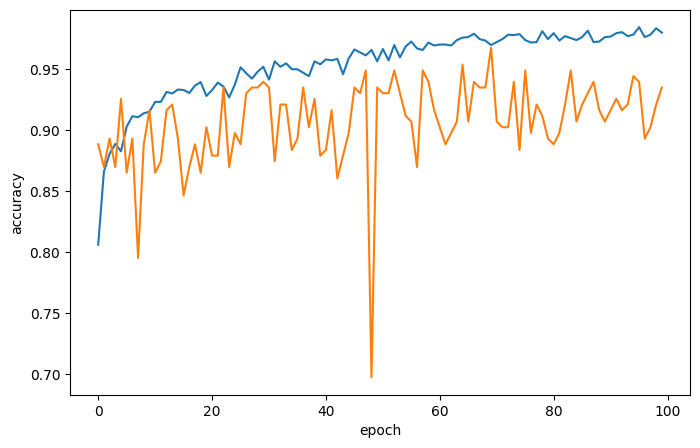

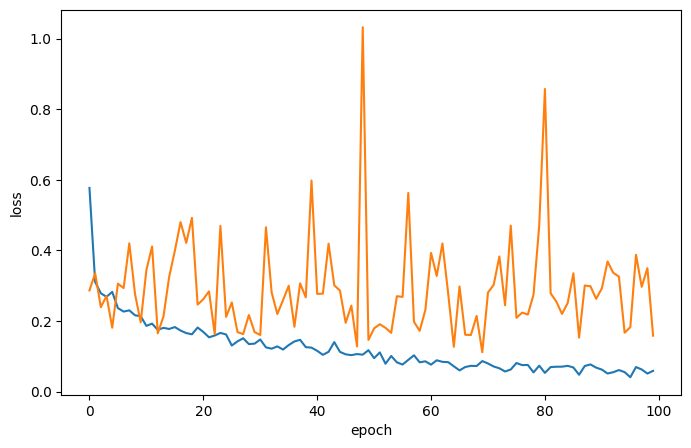

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_eff2.history["accuracy"])
plt.plot(history_eff2.history["val_accuracy"])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history_eff2.history["loss"])
plt.plot(history_eff2.history["val_loss"])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


4/4 [==============================] - 1s 166ms/step
              precision    recall  f1-score   support

          DF       1.00      0.98      0.99        43
         BCC       0.95      1.00      0.98        20

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.98      0.98      0.98        63



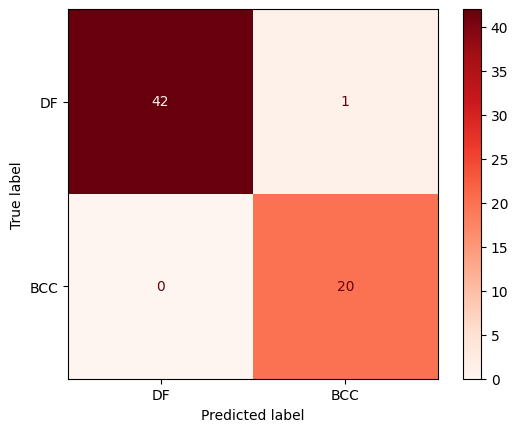

[1.0000000e+00 8.6438585e-11]


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
ava_labels = [
    DF,
    BCC
]
true_labels = flow_test.classes
predictions = model_eff_layer1.predict(flow_test)
y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=ava_labels)
print(cr)
disp = ConfusionMatrixDisplay(cm, display_labels=ava_labels)
disp.plot(cmap=plt.cm.Reds)
plt.show()
print(predictions[6])